In [3]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Massachusetts

## VEST Documentation

Election results from Massachusetts Secretary of the Commonwealth (https://electionstats.state.ma.us/) Precinct shapefile from MassGIS Bureau of Geographic Information (https://docs.digital.mass.gov/dataset/massgis-data-wards-and-precincts)

The following precincts were split by congressional district to match reporting units: Andover 7; Bellingham 4; Cambridge 3-2; Fall River 5B,6C; Palmer 1; Raynham 1,2; Sudbury 1; Winchendon 1. Andover 9A was merged with Andover 1 by an act of the MA legislature prior to the 2018 election. The following precinct divisions are authorized and defined for voting purposes but not for redistricting purposes by specific acts of the MA legislature and were split accordingly: Chicopee 6A,6B; Dracut 6; Hingham 5; Newburyport 1; Peabody 4-3; Quincy 2-3; Revere 2-3,5-1,5-2. Warren A and Warren B precincts were split based on polling place assignments in the Warren parcel shapefile.

G18USSDWAR - Elizabeth A. Warren (Democratic Party)  
G18USSRDIE - Geoff Diehl (Republican Party)  
G18USSUAYY - Shiva Ayyadurai (Unenrolled)  
G18USSOWRI - Write-in Votes  

G18GOVRBAK - Charles D. Baker (Republican Party)  
G18GOVDGON - Jay M. Gonzalez  (Democratic Party)  
G18GOVOWRI - Write-in Votes  

G18ATGDHEA - Maura Healey  (Democratic Party)  
G18ATGRMCM - James R. McMahon, III (Republican Party)  
G18ATGOWRI - Write-in Votes  

G18SOCDGAL - William Francis Galvin  (Democratic Party)  
G18SOCRAMO - Anthony M. Amore (Republican Party)  
G18SOCGSAN - Juan G. Sanchez, Jr (Green-Rainbow Party)  
G18SOCOWRI - Write-in Votes  

G18TREDGOL - Deborah B. Goldberg  (Democratic Party)  
G18TRERORR - Keiko M. Orrall (Republican Party)  
G18TREGGUE - Jamie M. Guerin (Green-Rainbow Party)  
G18TREOWRI - Write-in Votes  
  
G18AUDDBUM - Suzanne M. Bump  (Democratic Party)  
G18AUDRBRA - Helen Brady (Republican Party)  
G18AUDLFIS - Daniel Fishman (Libertarian Party)  
G18AUDGSTA - Edward J. Stamas (Green-Rainbow Party)  
G18AUDOWRI - Write-in Votes  

## Import VEST file

In [4]:
vest_ma_18 = gp.read_file("./raw-from-source/VEST/ma_2018/ma_2018.shp")

In [6]:
data_columns = ['G18USSDWAR', 'G18USSRDIE', 'G18USSUAYY', 'G18USSOWRI', 'G18GOVRBAK',
       'G18GOVDGON', 'G18GOVOWRI', 'G18ATGDHEA', 'G18ATGRMCM', 'G18ATGOWRI',
       'G18SOCDGAL', 'G18SOCRAMO', 'G18SOCGSAN', 'G18SOCOWRI', 'G18TREDGOL',
       'G18TRERORR', 'G18TREGGUE', 'G18TREOWRI', 'G18AUDDBUM', 'G18AUDRBRA',
       'G18AUDLFIS', 'G18AUDGSTA', 'G18AUDOWRI']

## Load Source Files

In [19]:
all_files = os.listdir("./raw-from-source/Election_Results/")
li = []
for file in all_files:
    if file  != ".DS_Store":
        ref = "./raw-from-source/Election_Results/"
        file_ref = ref+file
        file_prev = pd.read_csv(file_ref,engine='python',index_col=None)
        #Only keep the City/Town and Pct columns in one file, as they are duplicated
        #Delete unused columns in others
        if file != 'PD43+__2018_Secretary_of_the_Commonwealth_General_Election_including_precincts.csv':
            file_prev = file_prev.drop(['City/Town', 'Ward', 'Pct','Blanks','Total Votes Cast'], axis=1)
            file_prev = file_prev.drop([0])
        else:
            file_prev = file_prev.drop(['Blanks','Total Votes Cast'], axis=1)
            file_prev = file_prev.drop([0])
        for col in file_prev.columns:
            file_prev.rename(columns={col:col+"-"+file[12:len(file)-41]},inplace=True)
        li.append(file_prev)
    
#Define the dataframe, note we are add the loaded dataframes next to one another and not below
source_elections = pd.concat(li, axis=1, ignore_index=False)

In [22]:
#Rename columns to match VEST
source_elections.rename(columns={'City/Town-Secretary_of_the_Commonwealth':'City/Town',
       'Ward-Secretary_of_the_Commonwealth':'Ward',
       'Pct-Secretary_of_the_Commonwealth':'Pct',
       'William Francis Galvin-Secretary_of_the_Commonwealth':'G18SOCDGAL',
       'Anthony M. Amore-Secretary_of_the_Commonwealth':'G18SOCRAMO',
       'Juan G. Sanchez, Jr-Secretary_of_the_Commonwealth':'G18SOCGSAN',
       'All Others-Secretary_of_the_Commonwealth':'G18SOCOWRI',
       'Maura Healey-Attorney_General':'G18ATGDHEA',
       'James R. McMahon, III-Attorney_General':'G18ATGRMCM',
        'All Others-Attorney_General':'G18ATGOWRI',
       'Baker and Polito-Governor':'G18GOVRBAK',
        'Gonzalez and Palfrey-Governor':'G18GOVDGON',
       'All Others-Governor':'G18GOVOWRI', 
        'Elizabeth A. Warren-U_S_Senate':'G18USSDWAR',
       'Geoff Diehl-U_S_Senate':'G18USSRDIE',
        'Shiva Ayyadurai-U_S_Senate':'G18USSUAYY',
       'All Others-U_S_Senate':'G18USSOWRI', 
        'Suzanne M. Bump-Auditor':'G18AUDDBUM',
       'Helen Brady-Auditor':'G18AUDRBRA', 
        'Daniel Fishman-Auditor':'G18AUDLFIS',
       'Edward J. Stamas-Auditor':'G18AUDGSTA', 
        'All Others-Auditor':'G18AUDOWRI',
       'Deborah B. Goldberg-Treasurer':'G18TREDGOL', 
        'Keiko M. Orrall-Treasurer':'G18TRERORR',
       'Jamie M. Guerin-Treasurer':'G18TREGGUE', 
        'All Others-Treasurer':'G18TREOWRI'}
                       ,inplace=True)

In [23]:
#Filter out "TOTALS"
source_elections = source_elections[source_elections["City/Town"]!="TOTALS"]

In [25]:
#Convert columns to numbers
for race in data_columns:
        source_elections[race]=source_elections[race].astype(str)
        source_elections[race]=source_elections[race].apply(lambda x: x.replace(',',''))
        source_elections[race]=source_elections[race].astype(float)
        source_elections[race]=source_elections[race].astype(int)

<ipython-input-25-a6903e831078>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_elections[race]=source_elections[race].astype(str)
<ipython-input-25-a6903e831078>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_elections[race]=source_elections[race].apply(lambda x: x.replace(',',''))
<ipython-input-25-a6903e831078>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

## Run Statewide Totals Check

In [26]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [28]:
statewide_totals_check(vest_ma_18,source_elections,data_columns)

***Statewide Totals Check***
G18USSDWAR is equal 	VEST / RDH: 1633371
G18USSRDIE is equal 	VEST / RDH: 979210
G18USSUAYY is equal 	VEST / RDH: 91710
G18USSOWRI is equal 	VEST / RDH: 2799
G18GOVRBAK is equal 	VEST / RDH: 1781341
G18GOVDGON is equal 	VEST / RDH: 885770
G18GOVOWRI is equal 	VEST / RDH: 7504
G18ATGDHEA is equal 	VEST / RDH: 1874209
G18ATGRMCM is equal 	VEST / RDH: 804832
G18ATGOWRI is equal 	VEST / RDH: 1858
G18SOCDGAL is equal 	VEST / RDH: 1877065
G18SOCRAMO is equal 	VEST / RDH: 671300
G18SOCGSAN is equal 	VEST / RDH: 100428
G18SOCOWRI is equal 	VEST / RDH: 1731
G18TREDGOL is equal 	VEST / RDH: 1761282
G18TRERORR is equal 	VEST / RDH: 749596
G18TREGGUE is equal 	VEST / RDH: 92090
G18TREOWRI is equal 	VEST / RDH: 1590
G18AUDDBUM is equal 	VEST / RDH: 1606518
G18AUDRBRA is equal 	VEST / RDH: 801583
G18AUDLFIS is equal 	VEST / RDH: 108953
G18AUDGSTA is equal 	VEST / RDH: 67355
G18AUDOWRI is equal 	VEST / RDH: 1875


## Skip County Totals Check - No County Field in VEST Data

In [30]:
print(vest_ma_18)

                               WP_NAME  WARD PRECINCT DISTRICT       TOWN  \
0           Braintree Town Precinct 5B  None       5B       5B  BRAINTREE   
1           Braintree Town Precinct 6A  None       6A       6A  BRAINTREE   
2           Braintree Town Precinct 6B  None       6B       6B  BRAINTREE   
3       Chelsea City Ward 1 Precinct 1     1        1      1-1    CHELSEA   
4       Chelsea City Ward 1 Precinct 2     1        2      1-2    CHELSEA   
...                                ...   ...      ...      ...        ...   
2168  Chicopee City Ward 6 Precinct AN     6       AN     6-AN   CHICOPEE   
2169  Chicopee City Ward 6 Precinct AS     6       AS     6-AS   CHICOPEE   
2170  Chicopee City Ward 6 Precinct BW     6       BW     6-BW   CHICOPEE   
2171  Chicopee City Ward 6 Precinct BE     6       BE     6-BE   CHICOPEE   
2172           Andover Town Precinct 1  None        1        1    ANDOVER   

      TOWN_ID  G18USSDWAR  G18USSRDIE  G18USSUAYY  G18USSOWRI  ...  \
0    

## Precinct by Precinct Check

In [31]:
#Define a district column
source_elections["DISTRICT"]=np.where(source_elections["Ward"]=="-",source_elections["Pct"],source_elections["Ward"]+"-"+source_elections["Pct"])

In [32]:
#Create join columns in both files
vest_ma_18["join_col"]=vest_ma_18["TOWN"]+"-"+vest_ma_18["DISTRICT"]
source_elections["join_col"] = source_elections["City/Town"].str.upper()+"-"+source_elections["DISTRICT"]

In [34]:
#Confirm they are unique
print(vest_ma_18["join_col"].value_counts(dropna=False))
print(source_elections["join_col"].value_counts(dropna=False))

SCITUATE-5              1
BOSTON-1-6              1
NORTH ATTLEBOROUGH-3    1
BOSTON-14-8             1
BILLERICA-2             1
                       ..
BOSTON-10-1             1
PEABODY-6-1             1
WESTON-3                1
WINCHENDON-3            1
LYNN-5-2                1
Name: join_col, Length: 2173, dtype: int64
LAWRENCE-B-4     1
FRANKLIN-6       1
WESTFIELD-2-A    1
REVERE-4-1       1
HARWICH-4        1
                ..
WORCESTER-6-2    1
ASHLAND-3        1
WORCESTER-6-1    1
WINCHENDON-2     1
METHUEN-6        1
Name: join_col, Length: 2173, dtype: int64


In [36]:
#Attempt to join
first_attempt = pd.merge(vest_ma_18,source_elections,how="outer",on="join_col",indicator=True)
print(first_attempt["_merge"].value_counts())

both          2114
left_only       59
right_only      59
Name: _merge, dtype: int64


In [38]:
#Fix unjoined precincts
source_name_changes_dict = {'E. BRIDGEWATER-1':'EAST BRIDGEWATER-1',
'E. BRIDGEWATER-2':'EAST BRIDGEWATER-2',
'E. BRIDGEWATER-3':'EAST BRIDGEWATER-3',
'E. BRIDGEWATER-4':'EAST BRIDGEWATER-4',
'E. BROOKFIELD-1':'EAST BROOKFIELD-1',
'E. LONGMEADOW-1':'EAST LONGMEADOW-1',
'E. LONGMEADOW-2':'EAST LONGMEADOW-2',
'E. LONGMEADOW-3':'EAST LONGMEADOW-3',
'E. LONGMEADOW-4':'EAST LONGMEADOW-4',
'MANCHESTER-BY-THE-SEA-1':'MANCHESTER-1',
'N. ADAMS-1-1':'NORTH ADAMS-1-1',
'N. ADAMS-2-2':'NORTH ADAMS-2-2',
'N. ADAMS-3-3':'NORTH ADAMS-3-3',
'N. ADAMS-4-4':'NORTH ADAMS-4-4',
'N. ADAMS-5-5':'NORTH ADAMS-5-5',
'N. ANDOVER-1':'NORTH ANDOVER-1',
'N. ANDOVER-2':'NORTH ANDOVER-2',
'N. ANDOVER-3':'NORTH ANDOVER-3',
'N. ANDOVER-4':'NORTH ANDOVER-4',
'N. ANDOVER-5':'NORTH ANDOVER-5',
'N. ANDOVER-6':'NORTH ANDOVER-6',
'N. ANDOVER-7':'NORTH ANDOVER-7',
'N. ANDOVER-8':'NORTH ANDOVER-8',
'N. ATTLEBOROUGH-1':'NORTH ATTLEBOROUGH-1',
'N. ATTLEBOROUGH-2':'NORTH ATTLEBOROUGH-2',
'N. ATTLEBOROUGH-3':'NORTH ATTLEBOROUGH-3',
'N. ATTLEBOROUGH-4':'NORTH ATTLEBOROUGH-4',
'N. ATTLEBOROUGH-5':'NORTH ATTLEBOROUGH-5',
'N. ATTLEBOROUGH-6':'NORTH ATTLEBOROUGH-6',
'N. ATTLEBOROUGH-7':'NORTH ATTLEBOROUGH-7',
'N. ATTLEBOROUGH-8':'NORTH ATTLEBOROUGH-8',
'N. ATTLEBOROUGH-9':'NORTH ATTLEBOROUGH-9',
'N. BROOKFIELD-1':'NORTH BROOKFIELD-1',
'N. READING-1':'NORTH READING-1',
'N. READING-2':'NORTH READING-2',
'N. READING-3':'NORTH READING-3',
'N. READING-4':'NORTH READING-4',
'NEWBURYPORT-1-P':'NEWBURYPORT-1-1P',
'S. HADLEY-A':'SOUTH HADLEY-A',
'S. HADLEY-B':'SOUTH HADLEY-B',
'S. HADLEY-C':'SOUTH HADLEY-C',
'S. HADLEY-D':'SOUTH HADLEY-D',
'S. HADLEY-E':'SOUTH HADLEY-E',
'W. BOYLSTON-1':'WEST BOYLSTON-1',
'W. BOYLSTON-2':'WEST BOYLSTON-2',
'W. BRIDGEWATER-1':'WEST BRIDGEWATER-1',
'W. BRIDGEWATER-2':'WEST BRIDGEWATER-2',
'W. BROOKFIELD-1':'WEST BROOKFIELD-1',
'W. NEWBURY-1':'WEST NEWBURY-1',
'W. SPRINGFIELD-1':'WEST SPRINGFIELD-1',
'W. SPRINGFIELD-2':'WEST SPRINGFIELD-2',
'W. SPRINGFIELD-3':'WEST SPRINGFIELD-3',
'W. SPRINGFIELD-4':'WEST SPRINGFIELD-4',
'W. SPRINGFIELD-5':'WEST SPRINGFIELD-5',
'W. SPRINGFIELD-6':'WEST SPRINGFIELD-6',
'W. SPRINGFIELD-7':'WEST SPRINGFIELD-7',
'W. SPRINGFIELD-8':'WEST SPRINGFIELD-8',
'W. STOCKBRIDGE-1':'WEST STOCKBRIDGE-1',
'W. TISBURY-1':'WEST TISBURY-1'}

In [39]:
#Apply name changes to get the final joins
source_elections["join_col"] = source_elections["join_col"].map(source_name_changes_dict).fillna(source_elections["join_col"])

In [40]:
#Join them again
final_join = pd.merge(vest_ma_18,source_elections,how="outer",on="join_col",indicator=True)
final_join["_merge"].value_counts()

both          2173
left_only        0
right_only       0
Name: _merge, dtype: int64

In [41]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [42]:
precinct_votes_check(final_join[final_join["_merge"]=="both"],data_columns,True,"join_col",print_level=0)


There are  2173  total rows
0  of these rows have election result differences
2173  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]


## Shapefile Check

<AxesSubplot:>

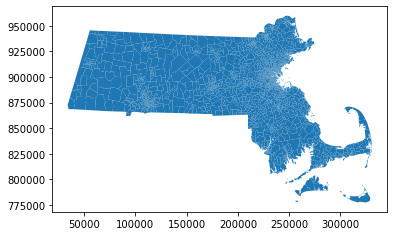

In [43]:
vest_ma_18.plot()

In [45]:
ma_check = gp.read_file("./raw-from-source/Shapefile/wardsprecincts_poly/WARDSPRECINCTS_POLY.shp")

<AxesSubplot:>

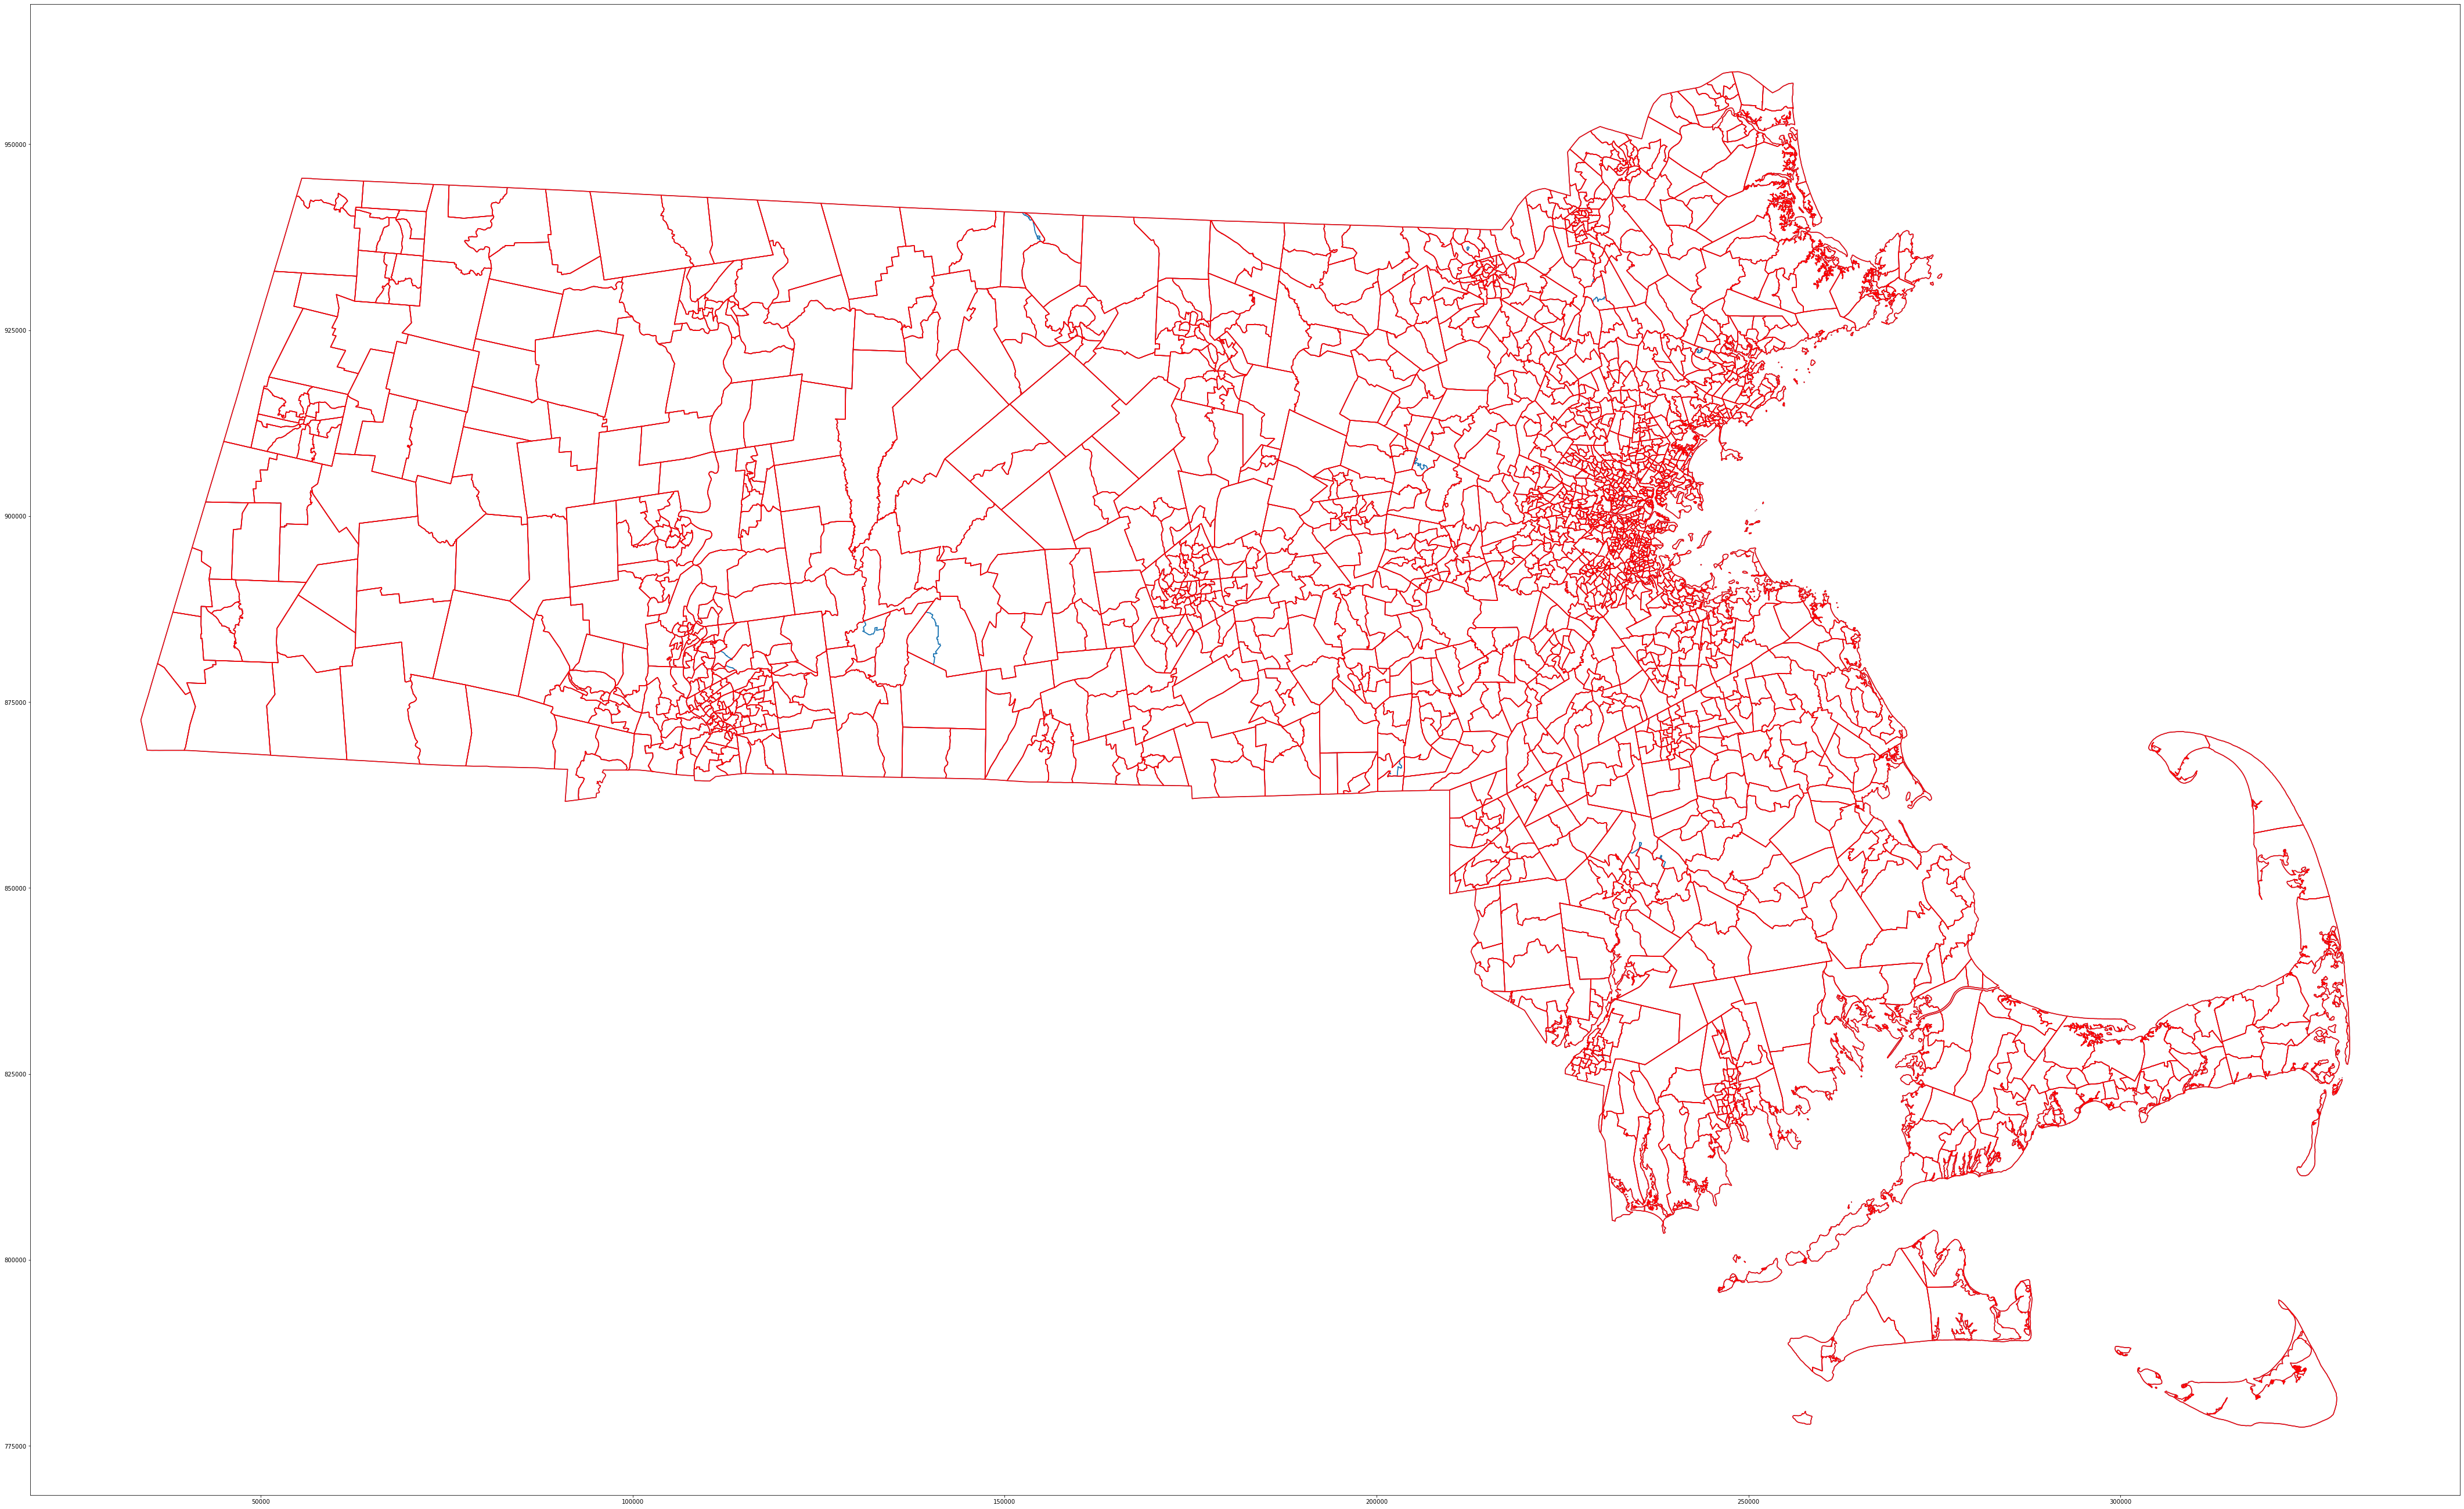

In [46]:
ax = vest_ma_18.boundary.plot(figsize=(75,75))
ma_check.boundary.plot(ax=ax,color="red")

<AxesSubplot:>

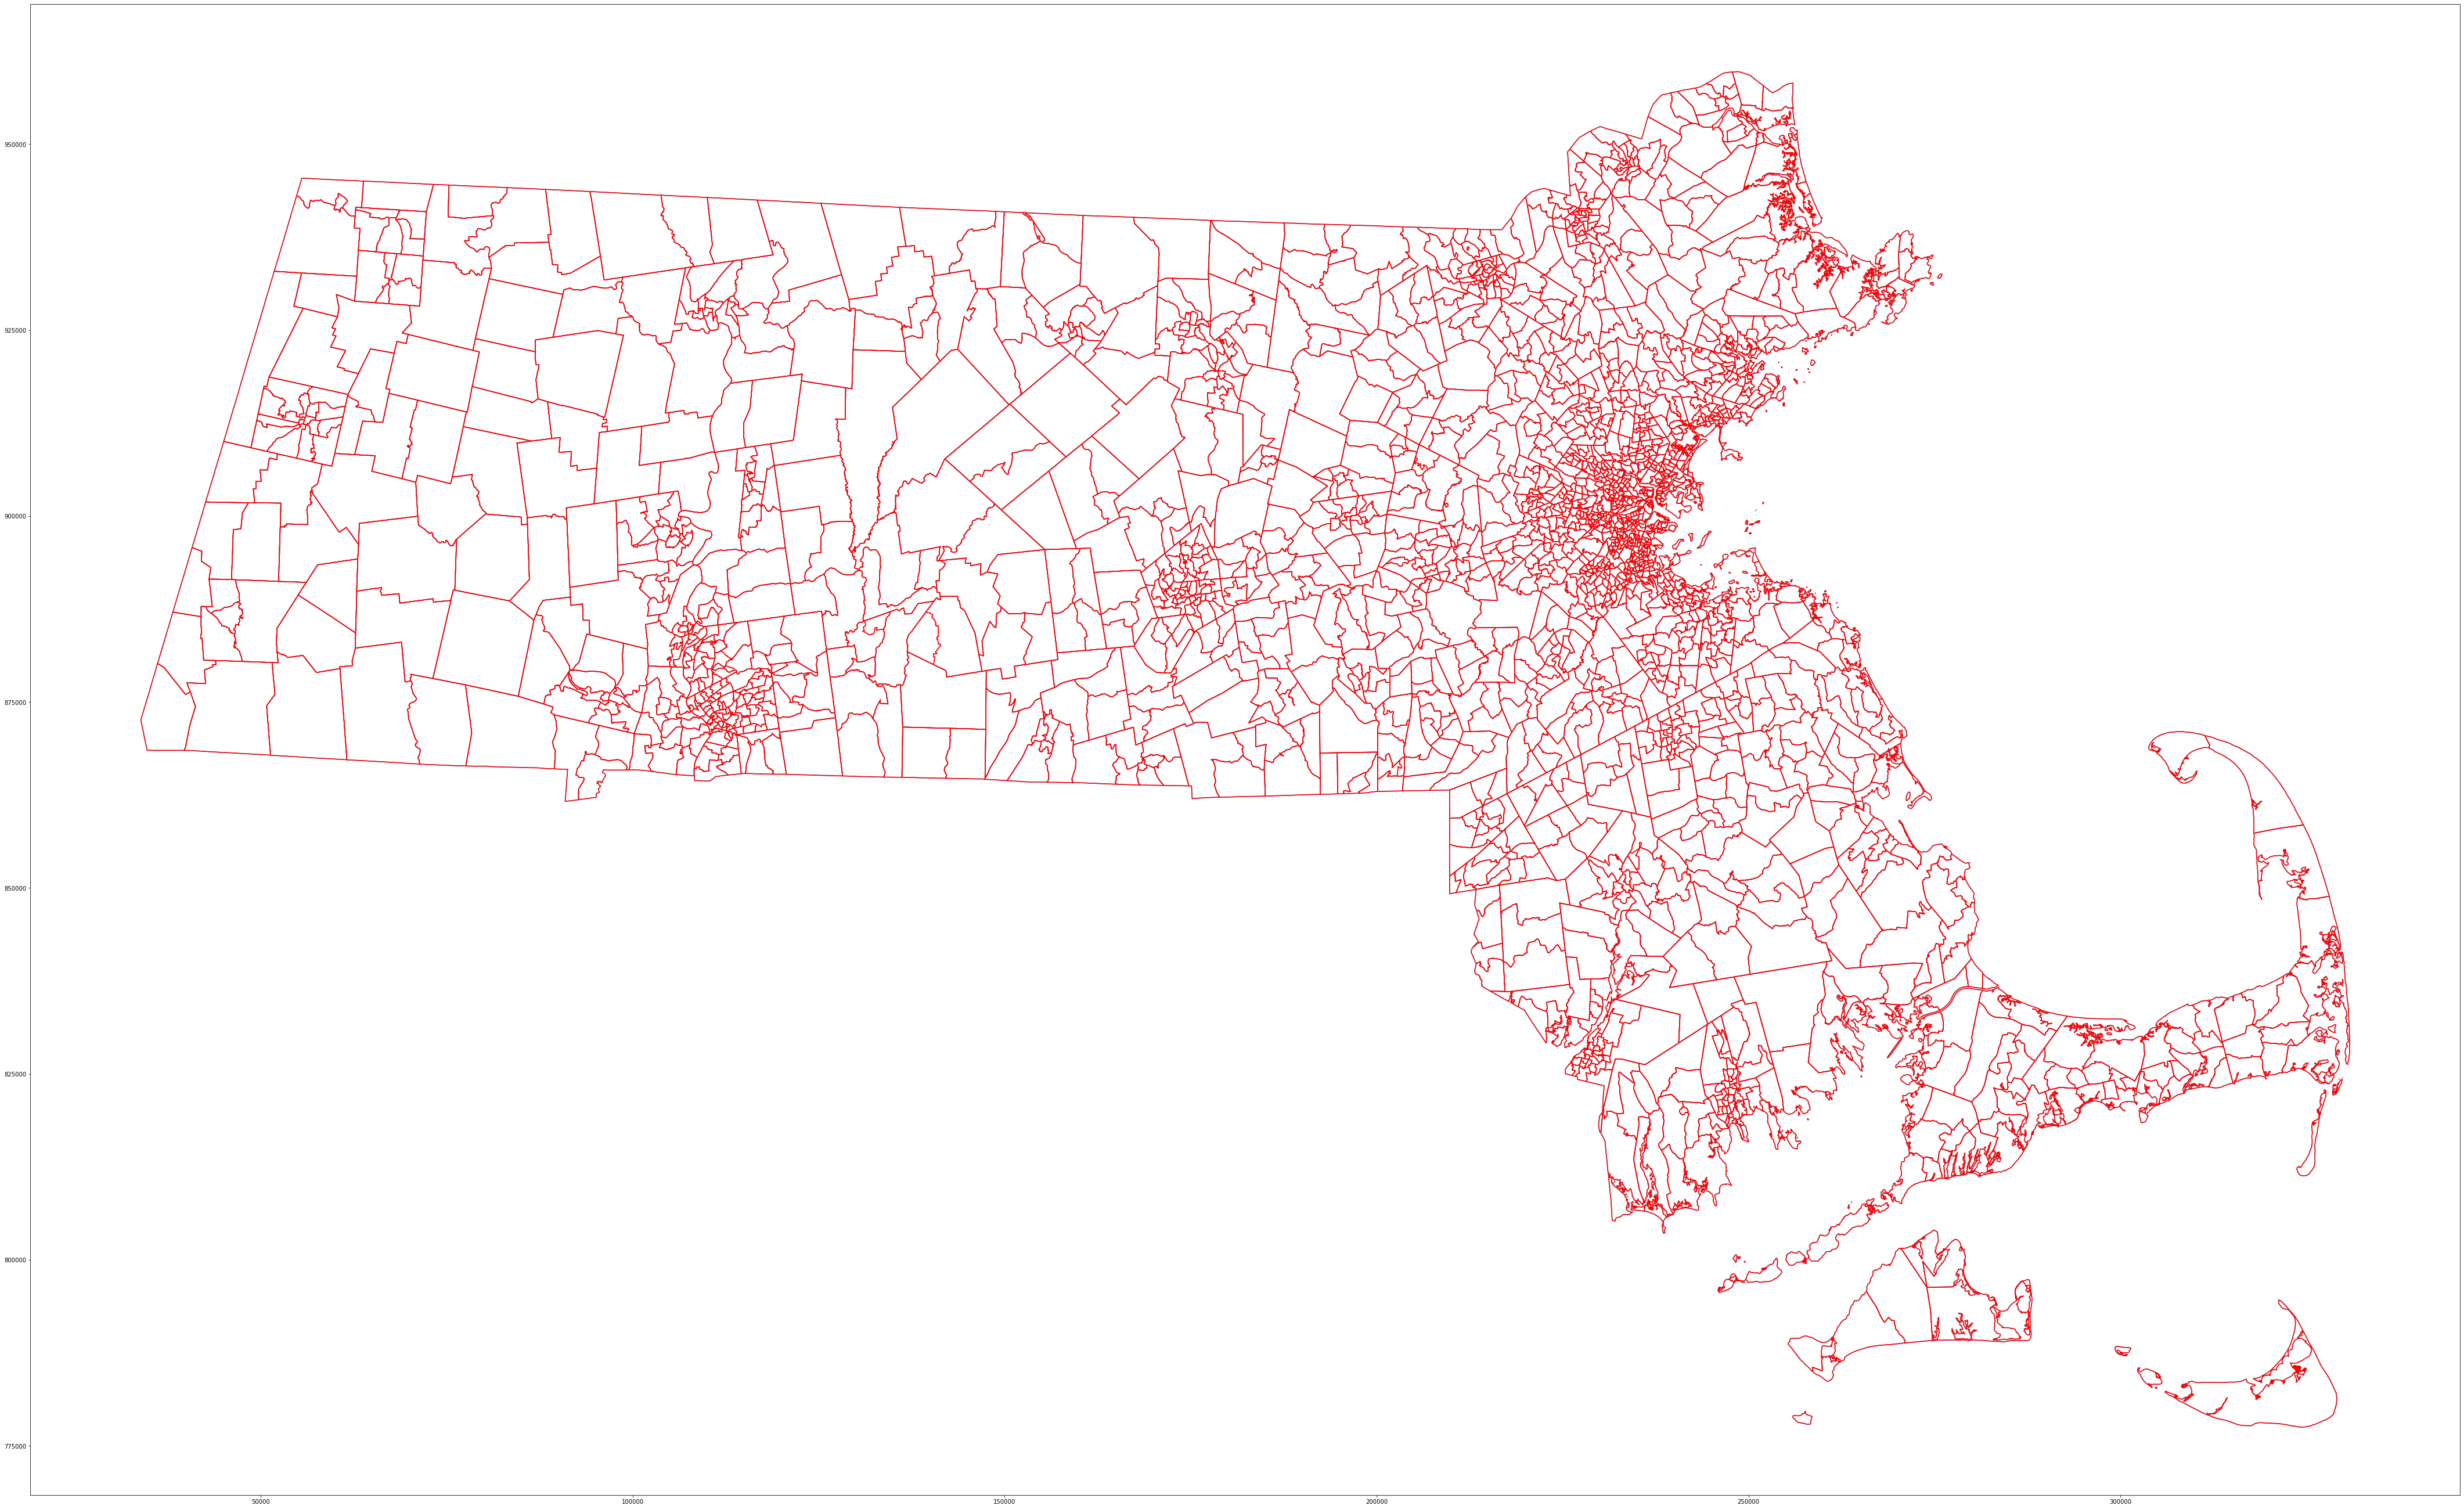

In [47]:
ax = ma_check.boundary.plot(figsize=(75,75))
vest_ma_18.boundary.plot(ax=ax,color="red")